In [2]:
pip install opendatasets

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import opendatasets as od

In [4]:
od.download(
    "https://www.kaggle.com/datasets/carrie1/ecommerce-data/data")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: vladimir1992
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/carrie1/ecommerce-data


In [5]:
df = pd.read_csv('/content/ecommerce-data/data.csv', encoding='Windows-1251')

In [6]:
len(df)

541909

In [7]:
df.isna().mean() # Много пропусков в переменной CustomerID

,0
InvoiceNo,0.000000
StockCode,0.000000
Description,0.002683
Quantity,0.000000
InvoiceDate,0.000000
UnitPrice,0.000000
CustomerID,0.249267
Country,0.000000


In [8]:
df[df['CustomerID'].isna() == True].head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom


In [9]:
df = df.dropna(subset=['CustomerID'], how='all') # Удаляю строки с пустым значениями

In [12]:
df.isna().mean()

,0
InvoiceNo,0.0
StockCode,0.0
Description,0.0
Quantity,0.0
InvoiceDate,0.0
UnitPrice,0.0
CustomerID,0.0
Country,0.0


In [10]:
df.dtypes

,0
InvoiceNo,object
StockCode,object
Description,object
Quantity,int64
InvoiceDate,object
UnitPrice,float64
CustomerID,float64
Country,object


In [11]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']) # Меняю тип переменной InvoiceDate

In [13]:
df['amount'] = df['UnitPrice'] * df['Quantity'] # Вычисляю сумму заказанных товаров

In [15]:
def prepare_rfm(df):
  # Подготовка данных для RFM-анализа
  analysis_date = df['InvoiceDate'].max()
   # Датой, от которой будет анализироваться Recency,
   # я взял дату последнего заказа в данных

  rfm = df.groupby('CustomerID', as_index=False).agg( # Подсчет метрик
             Recency=('InvoiceDate', lambda x: (analysis_date - x.max()).days),
             Frequency=('amount', 'count'),
             Monetary=('amount', 'sum'))
  return rfm

In [17]:
rfm_df = prepare_rfm(df)

In [19]:
def rfm_distributions(rfm_df): # Визуализация распределения RFM-метрик

    fig, axes = plt.subplots(1, 3, figsize=(12, 5))
    fig.suptitle('Распределение RFM-метрик', fontsize=14)

    # Recency
    sns.histplot(data=rfm_df, x='Recency', bins=30, ax=axes[0])
    axes[0].set_title('Recency')
    axes[0].set_xlabel('Дни с последней покупки')

    # Frequency
    sns.histplot(data=rfm_df, x='Frequency', bins=30, ax=axes[1])
    axes[1].set_title('Frequency')
    axes[1].set_xlabel('Количество покупок')

    # Monetary
    sns.histplot(data=rfm_df, x='Monetary', bins=30, ax=axes[2])
    axes[2].set_title('Monetary')
    axes[2].set_xlabel('Общая сумма покупок')
    plt.xticks(rotation=45)

    plt.tight_layout()
    return fig

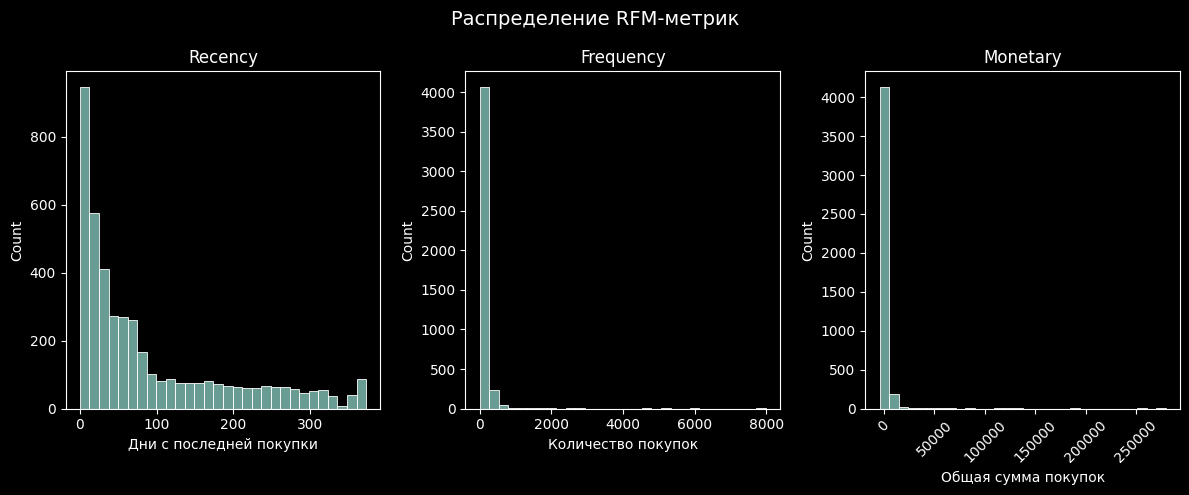

In [20]:
rfm_histplot = rfm_distributions(rfm_df)

In [21]:
def quantile_segmentation(df, n_segments=5): # Квантильная сегментация
  # n_segments это кол-во сегментов для каждой метрики, по умолчанию - 5
  df_rfm = df.copy()

  # Cегментация
  df_rfm['R'] = pd.qcut(df_rfm['Recency'], q=n_segments, labels=[5, 4, 3, 2, 1])
  # Чем меньше давность, тем выше балл
  df_rfm['F'] = pd.qcut(df_rfm['Frequency'], q=n_segments, labels=[1, 2, 3, 4, 5])
  # Чем больше частота, тем выше балл
  df_rfm['M'] = pd.qcut(df_rfm['Monetary'], q=n_segments, labels=[1, 2, 3, 4, 5])
  # Чем больше сумма покупок, тем выше балл

  # Объединение RFM баллов в один общий балл
  df_rfm['RFM_Score'] = df_rfm['R'].astype(str) + df_rfm['F'].astype(str) \
                                                + df_rfm['M'].astype(str)

  return df_rfm

In [22]:
df_segmented = quantile_segmentation(rfm_df)

In [23]:
df_segmented.head()

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM_Score
0,12346.0,325,2,0.00,1,1,1,111
1,12347.0,1,182,4310.00,5,5,5,555
2,12348.0,74,31,1797.24,2,3,4,234
3,12349.0,18,73,1757.55,4,4,4,444
4,12350.0,309,17,334.40,1,2,2,122


In [24]:
df_segmented.query('RFM_Score == "555"') # Самый лояльный сегмент клиентов

,CustomerID,Recency,Frequency,Monetary,R,F,M,RFM_Score
1,12347.0,1,182,4310.00,5,5,5,555
12,12359.0,7,254,6245.53,5,5,5,555
15,12362.0,2,274,5154.58,5,5,5,555
56,12417.0,2,198,3578.80,5,5,5,555
71,12433.0,0,420,13375.87,5,5,5,555
...,...,...,...,...,...,...,...,...
4324,18223.0,1,299,6315.23,5,5,5,555
4326,18225.0,2,286,5361.02,5,5,5,555
4342,18245.0,6,177,2507.56,5,5,5,555
4361,18272.0,2,170,3064.78,5,5,5,555
